In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from matplotlib import pyplot
from keras.callbacks import History 
import matplotlib.image as mpimg
from PIL import Image

ModuleNotFoundError: No module named 'keras_tuner'

In [2]:
#get the data and convert it into an numpy array 
#important: Structure of the folders!
labels = ['Flooding', 'Regular_State']
img_height_full = 100
img_width_full = 200
#batch_size = 16
#data_dir = 'E:/Python Projekt 5_2 Extraktion/Training_Validation/'
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = np.zeros(2)
        class_num[labels.index(label)] = 1
        for img in os.listdir(path):
            try:
                img_arr = mpimg.imread(os.path.join(path, img)) 
                R, G, B = img_arr[:,:,0], img_arr[:,:,1], img_arr[:,:,2]
                img_arr = 0.2989 * R + 0.5870 * G + 0.1140 * B #using a standard converting formula to get greyscale
                resized_crop = img_arr[1300:1500, 300:700]
                resized_arr = cv2.resize(resized_crop, (200,100))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e) #if there is a picture which can't be loaded
            
    return np.array(data,dtype=object)


(200, 400)
0.51529527


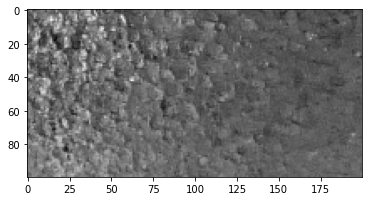

In [3]:
#test with one picture, if the image processing works. Can be deleted
img_arr = mpimg.imread('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test/Flooding/Flooding_2136.png')
R, G, B = img_arr[:,:,0], img_arr[:,:,1], img_arr[:,:,2]
img_arr = 0.2989 * R + 0.5870 * G + 0.1140 * B
resized_crop = img_arr[1300:1500, 300:700]
print(resized_crop.shape)
plt.imshow(resized_crop)
resized_arr = cv2.resize(resized_crop, (200,100)) # Reshaping images to preferred size
print(resized_arr[1][2])
plt.imshow(resized_arr,cmap='gray')

In [4]:
#get the data in numpy-array with get_data
#important: In folder Train are 2 folders with the labels 'Flooding' and 'Regular_State'
train = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Train')
#it takes time
#change of directory necessary

In [5]:
#important: In folder Validation are 2 folders with the labels 'Flooding' and 'Regular_State'
val = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Validation')

Text(0.5, 1.0, 'Regular_State')

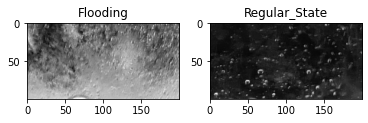

In [6]:
#show example pictures
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(train[1][0],cmap='gray')
plt.title(labels[0])
fig.add_subplot(1,2,2)
plt.imshow(train[-1][0],cmap='gray')
plt.title(labels[1])

In [7]:
#get the right numpy structure
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_train = np.array(x_train)
x_val = np.array(x_val)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
y_val = np.array(y_val)

In [8]:
#delete previously trained model 
keras.backend.clear_session()
print(tf.__version__)
del model

2.3.0


NameError: name 'model' is not defined

In [9]:
#create a simple model 
model = Sequential()
model.add(Conv2D(16, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model.add(Flatten())
model.add(Dense(2, activation="softmax"))

In [10]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 200, 16)      272       
_________________________________________________________________
flatten (Flatten)            (None, 320000)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 640002    
Total params: 640,274
Trainable params: 640,274
Non-trainable params: 0
_________________________________________________________________


In [12]:
keras.backend.clear_session()
history = History() #for saving the metrics in each epoch
model_1 = model.fit(
    x_train,
    y_train,
    epochs=5,
    validation_data = (x_val, y_val),
    batch_size=16,
    callbacks=[history]
) 

Epoch 1/5
194/194 [==============================] - 7s 38ms/step - loss: 0.6379 - accuracy: 0.8116 - val_loss: 0.3380 - val_accuracy: 0.8283
Epoch 2/5
194/194 [==============================] - 7s 37ms/step - loss: 0.0620 - accuracy: 0.9880 - val_loss: 0.1357 - val_accuracy: 0.9505
Epoch 3/5
194/194 [==============================] - 7s 37ms/step - loss: 0.0127 - accuracy: 0.9990 - val_loss: 0.2949 - val_accuracy: 0.8797
Epoch 4/5
194/194 [==============================] - 7s 36ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3266 - val_accuracy: 0.8739
Epoch 5/5
194/194 [==============================] - 7s 37ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2175 - val_accuracy: 0.9195


In [13]:
train_loss = model_1.history['loss']
val_loss   = model_1.history['val_loss']

In [23]:
model_1.history['accuracy']


[0.8115707635879517, 0.988041341304779, 0.999030351638794, 1.0, 1.0]

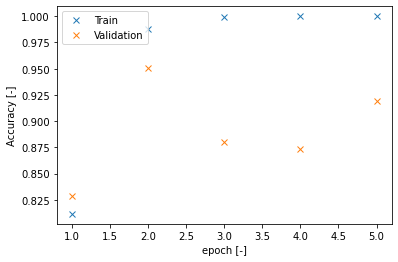

In [31]:
# Plot training & validation accuracy values
plt.plot(range(1,6),model_1.history['accuracy'],'x')
plt.plot(range(1,6),model_1.history['val_accuracy'],'x')
plt.ylabel('Accuracy [-]')
plt.xlabel('epoch [-]')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

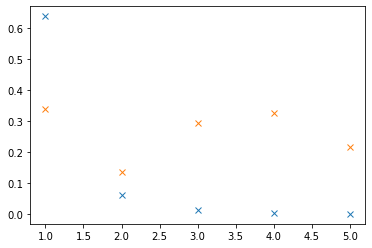

In [27]:
# plot of the loss and the validation loss over the epoch
plt.figure()
plt.plot(range(1,6), train_loss,'x')
plt.plot(range(1,6), val_loss,'x')

In [28]:
#get the test data in an numpy-array
test = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test')
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = np.array(y_test)

In [29]:
#get the predictions and calculate the recall and precision
predictions = model.predict(x_test)
#positive class: flooded
#negative class: normal
#false positive: prediction is flooded, but it is a normal state
#false negativ : prediction is normal, but it is a flooded state
y_test[:10]
#precision = tp/(tp+fp)
#recall = tp/(tp+fn)
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1

print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

There are 534 true positive, 131 false positive, 0 false negativ and 368 true negativ
The calculations for the recall and the precision are:
recall=1.0
precision=0.8030075187969925


In [30]:
model.evaluate(x_test,y_test)

33/33 [==============================] - 1s 17ms/step - loss: 0.3616 - accuracy: 0.8732


[0.36158287525177, 0.8731849193572998]

In [25]:
#function for the keras_tuner which change different parameters of the model to optimize
#change of filter size and learning rate
def build_model(hp):
    model_opt_1 = Sequential()
    model_opt_1.add(Conv2D(hp.Choice("filters",[8,16,24,32,40,48]),kernel_size=(4, 4),activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_1.add(Flatten())
    model_opt_1.add(Dense(2, activation="softmax"))
    model_opt_1.compile(
    optimizer=keras.optimizers.Adam(
    hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)
    return model_opt_1

In [26]:
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    #directory='E:/', #change directory if a save is desired
    #project_name='CNN_layer_learning_rate',
)
tuner.search_space_summary()
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val),batch_size = 16)


Trial 11 Complete [00h 00m 33s]
val_accuracy: 0.5179437398910522

Best val_accuracy So Far: 0.9757516980171204
Total elapsed time: 00h 06m 04s
INFO:tensorflow:Oracle triggered exit


In [27]:
#get the best model out of the tuner
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first CNN
layer is {best_hps.get('filters')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first CNN
layer is 24 and the optimal learning rate for the optimizer
is 0.001.



In [30]:
best_model.evaluate(x_test,y_test)
#best.save('E:/best_model/Acc_99')
best_model.summary()

33/33 [==============================] - 1s 22ms/step - loss: 0.1405 - accuracy: 0.9409
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 200, 24)      408       
_________________________________________________________________
flatten (Flatten)            (None, 480000)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 960002    
Total params: 960,410
Trainable params: 960,410
Non-trainable params: 0
_________________________________________________________________


In [31]:
#get the prediction and calculate the recall ans precision
predictions = best_model.predict(x_test)
y_test[:10]
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1
print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

There are 534 true positive, 61 false positive, 0 false negativ and 438 true negativ
The calculations for the recall and the precision are:
recall=1.0
precision=0.8974789915966387


In [63]:
#create optimized model 
model_opt = Sequential()
model_opt.add(Conv2D(24, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model_opt.add(Flatten())
model_opt.add(Dense(2, activation="softmax"))

In [64]:
model_opt.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [65]:
model_opt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 200, 24)      408       
_________________________________________________________________
flatten_1 (Flatten)          (None, 480000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 960002    
Total params: 960,410
Trainable params: 960,410
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = History() #for saving the metrics in each epoch
#del model_opt_1
#keras.backend.clear_session()
model_opt_1 = model_opt.fit(
    x_train,
    y_train,
    epochs=5,
    validation_data = (x_val, y_val),
    batch_size=16,
    callbacks=[history]
) 

Epoch 1/5
194/194 [==============================] - 9s 44ms/step - loss: 0.6059 - accuracy: 0.8384 - val_loss: 0.1326 - val_accuracy: 0.9670
Epoch 2/5
194/194 [==============================] - 9s 45ms/step - loss: 0.0507 - accuracy: 0.9858 - val_loss: 0.0499 - val_accuracy: 0.9845
Epoch 3/5
194/194 [==============================] - 9s 45ms/step - loss: 0.0117 - accuracy: 0.9984 - val_loss: 0.2689 - val_accuracy: 0.8788
Epoch 4/5
194/194 [==============================] - 9s 45ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0969 - val_accuracy: 0.9670
Epoch 5/5
194/194 [==============================] - 9s 45ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1009 - val_accuracy: 0.9670


In [67]:
train_loss = model_opt_1.history['loss']
val_loss   = model_opt_1.history['val_loss']


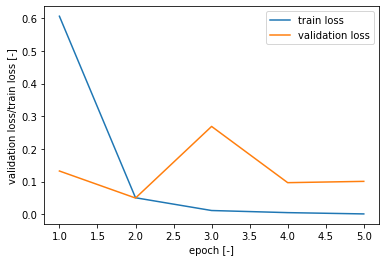

In [80]:
# plot of the loss and the validation loss over the epoch
plt.figure()
plt.plot(range(1,6), train_loss, label = 'train loss')
plt.plot(range(1,6), val_loss, label = 'validation loss')
plt.xlabel('epoch [-]')
plt.ylabel('validation loss/train loss [-]')
plt.legend()

In [70]:
#get the prediction and calculate the recall ans precision
predictions = model_opt.predict(x_test)
y_test[:10]
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1

print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

There are 534 true positive, 167 false positive, 0 false negativ and 332 true negativ
The calculations for the recall and the precision are:
recall=1.0
precision=0.7617689015691869


In [71]:
model_opt.evaluate(x_test,y_test)

33/33 [==============================] - 1s 25ms/step - loss: 0.5099 - accuracy: 0.8383


[0.5098578929901123, 0.8383349180221558]

In [ ]:
#optimize kernel_size

In [81]:
def build_model_2(hp):
    model_opt_1 = Sequential()
    model_opt_1.add(Conv2D(24,hp.Choice("Kernels",[2,3,4,5,6,7,8]),activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_1.add(Flatten())
    model_opt_1.add(Dense(2, activation="softmax"))
    model_opt_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)
    return model_opt_1

In [82]:
tuner_2 = RandomSearch(
    build_model_2,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory='E:/',
    project_name='CNN_layer_learning_rate_2',
)
tuner_2.search_space_summary()
tuner_2.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val),batch_size = 16)


Trial 7 Complete [00h 00m 39s]
val_accuracy: 0.9786614775657654

Best val_accuracy So Far: 0.9903006851673126
Total elapsed time: 00h 05m 00s
INFO:tensorflow:Oracle triggered exit


In [83]:
best_model_2 = tuner_2.get_best_models()[0]
best_hps_2 = tuner_2.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal kernel_size is {}.'.format(best_hps_2.get('Kernels')))


The hyperparameter search is complete. The optimal kernel_size is 4.


In [84]:
#add a conv2D layer and optimise the filter size
def build_model_3(hp):
    model_opt_1 = Sequential()
    model_opt_1.add(Conv2D(24,4,activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_1.add(Conv2D(hp.Choice('Filters',[8,16,24,32,40,48]),4,activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_1.add(Flatten())
    model_opt_1.add(Dense(2, activation="softmax"))
    model_opt_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)
    return model_opt_1

In [85]:
tuner_3 = RandomSearch(
    build_model_3,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory='E:/',
    project_name='CNN_layer_learning_rate_3',
)
tuner_3.search_space_summary()
tuner_3.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val),batch_size = 16)


Trial 6 Complete [00h 03m 37s]
val_accuracy: 0.9578079581260681

Best val_accuracy So Far: 0.9980601370334625
Total elapsed time: 00h 22m 05s
INFO:tensorflow:Oracle triggered exit


In [86]:
best_model_3 = tuner_3.get_best_models()[0]
best_hps_3 = tuner_3.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal Filter for the second layer is {}.'.format(best_hps_3.get('Filters')))

The hyperparameter search is complete. The optimal Filter for the second layer is 40.


In [89]:
best_model_3.evaluate(x_test,y_test)
#best.save('E:/best_model/Acc_99')
best_model_3.summary()

33/33 [==============================] - 3s 84ms/step - loss: 0.2384 - accuracy: 0.8771
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 200, 24)      408       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 200, 40)      15400     
_________________________________________________________________
flatten (Flatten)            (None, 800000)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1600002   
Total params: 1,615,810
Trainable params: 1,615,810
Non-trainable params: 0
_________________________________________________________________


In [88]:
#get the predictions and calculate the recall and precision
predictions = best_model_3.predict(x_test)
y_test[:10]
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1
        
print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

There are 534 true positive, 127 false positive, 0 false negativ and 372 true negativ
The calculations for the recall and the precision are:
recall=1.0
precision=0.8078668683812406


In [96]:
#add MaxPooling2D layer
def build_model_4(hp):
    model_opt_2 = Sequential()
    model_opt_2.add(Conv2D(24, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_2.add(MaxPooling2D((2, 2),padding='same'))
    model_opt_2.add(Conv2D(40, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt_2.add(Flatten())
    model_opt_2.add(Dense(2, activation="softmax"))
    
    model_opt_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)
    return model_opt_2

In [97]:
tuner_3 = RandomSearch(
    build_model_4,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory='E:/',
    project_name='CNN_layer_learning_rate_3',
)
tuner_3.search_space_summary()
tuner_3.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val),batch_size = 16)

Trial 1 Complete [00h 06m 51s]
val_accuracy: 0.9849660396575928

Best val_accuracy So Far: 0.9849660396575928
Total elapsed time: 00h 06m 51s
INFO:tensorflow:Oracle triggered exit


In [100]:
best = tuner_3.get_best_models()[0]
best.evaluate(x_test,y_test)

33/33 [==============================] - 1s 39ms/step - loss: 0.1163 - accuracy: 0.9593


[0.1162983849644661, 0.9593417048454285]

In [112]:
#best.save('E:/best_model/Acc_97')

INFO:tensorflow:Assets written to: E:/best_model/Acc_97\assets


INFO:tensorflow:Assets written to: E:/best_model/Acc_97\assets


In [62]:
#get the predictions and calculate the recall and precision
predictions = best.predict(x_test)

y_test[:10]
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1

print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

NameError: name 'best' is not defined

In [59]:
model_best = Sequential()
model_best.add(Conv2D(24, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model_best.add(MaxPooling2D((2, 2),padding='same'))
model_best.add(Conv2D(40, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model_best.add(Flatten())
model_best.add(Dense(2, activation="softmax"))
    
model_best.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)

In [60]:
history = History() #for saving the metrics in each epoch

best_epoch_test = model_best.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data = (x_val, y_val),
    batch_size=16,
    callbacks=[history]) 
    

Epoch 1/20
194/194 [==============================] - 20s 104ms/step - loss: 0.3657 - accuracy: 0.8400 - val_loss: 0.2082 - val_accuracy: 0.9195
Epoch 2/20
194/194 [==============================] - 20s 104ms/step - loss: 0.0910 - accuracy: 0.9686 - val_loss: 0.0304 - val_accuracy: 0.9922
Epoch 3/20
194/194 [==============================] - 20s 104ms/step - loss: 0.0586 - accuracy: 0.9783 - val_loss: 0.3355 - val_accuracy: 0.8933
Epoch 4/20
194/194 [==============================] - 20s 105ms/step - loss: 0.0422 - accuracy: 0.9855 - val_loss: 1.1767 - val_accuracy: 0.7595
Epoch 5/20
194/194 [==============================] - 20s 104ms/step - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.1733 - val_accuracy: 0.9515
Epoch 6/20
194/194 [==============================] - 20s 105ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.2469 - val_accuracy: 0.9437
Epoch 7/20
194/194 [==============================] - 20s 104ms/step - loss: 0.0063 - accuracy: 0.9987 - val_loss: 0.1386 - val_ac

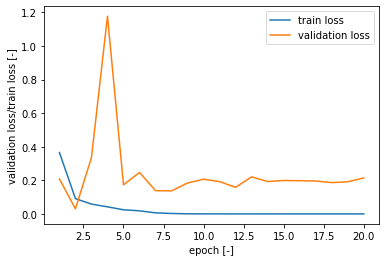

In [61]:
train_loss = best_epoch_test.history['loss']
val_loss   = best_epoch_test.history['val_loss']
# plot of the loss and the validation loss over the epoch
plt.figure()
plt.plot(range(1,21), train_loss, label = 'train loss')
plt.plot(range(1,21), val_loss, label = 'validation loss')
plt.xlabel('epoch [-]')
plt.ylabel('validation loss/train loss [-]')
plt.legend()

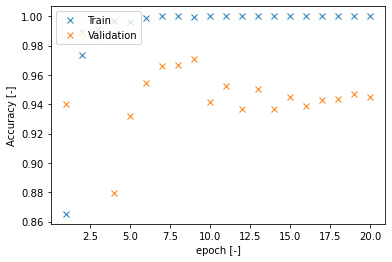

In [54]:
# Plot training & validation accuracy values
plt.plot(range(1,21),best_epoch_test.history['accuracy'],'x')
plt.plot(range(1,21),best_epoch_test.history['val_accuracy'],'x')
plt.ylabel('Accuracy [-]')
plt.xlabel('epoch [-]')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# following code just for testing

In [56]:
history = History() #for saving the metrics in each epoch

model_opt_3 = model_opt_2.fit(
    x_train,
    y_train,
    epochs=2,
    validation_data = (x_val, y_val),
    batch_size=16,
    callbacks=[history]) 
    

NameError: name 'model_opt_2' is not defined

The optimal epoch for this model is 1


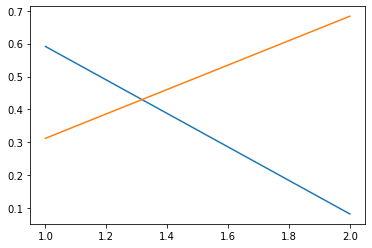

In [72]:
train_loss = model_opt_3.history['loss']
val_loss   = model_opt_3.history['val_loss']
plt.figure()
plt.plot(range(1,3), train_loss)
plt.plot(range(1,3), val_loss)
print('The optimal epoch for this model is {}'.format(val_loss.index(min(val_loss))+1))

In [73]:
model_opt_2.evaluate(x_test,y_test)

33/33 [==============================] - 2s 58ms/step - loss: 1.1970 - accuracy: 0.7522


[1.196956992149353, 0.7521781325340271]

In [94]:
del model_test
del model_test_1
model_test = Sequential()
model_test.add(Conv2D(32, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model_test.add(MaxPooling2D((2, 2),padding='same'))
model_test.add(Conv2D(16, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model_test.add(Flatten())
model_test.add(Dense(2, activation="softmax"))

In [95]:
model_test.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [96]:
model_test.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 200, 32)      544       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 100, 32)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 100, 16)       8208      
_________________________________________________________________
flatten_7 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 160002    
Total params: 168,754
Trainable params: 168,754
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = History() #for saving the metrics in each epoch
model_test_1 = model_test.fit(
    x_train,
    y_train,
    epochs=2,
    validation_data = (x_val, y_val),
    batch_size=16,
    callbacks=[history]
) 

NameError: name 'getModel' is not defined

The optimal epoch for this model is 1


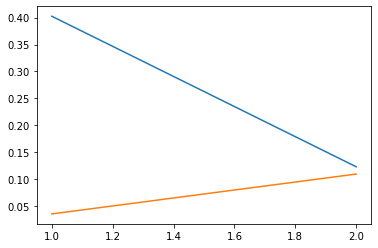

In [99]:
train_loss = model_test_1.history['loss']
val_loss   = model_test_1.history['val_loss']
plt.figure()
plt.plot(range(1,3), train_loss)
plt.plot(range(1,3), val_loss)
print('The optimal epoch for this model is {}'.format(val_loss.index(min(val_loss))+1))

In [100]:
model_test.evaluate(x_test,y_test)

33/33 [==============================] - 1s 38ms/step - loss: 0.4148 - accuracy: 0.8238


[0.4148467481136322, 0.8238141536712646]